In [49]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [50]:
from IPython import display
display.set_matplotlib_formats('svg') # Improve matplotlib visual quality

<ipython-input-50-dcd5f3b50b37>:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg') # Improve matplotlib visual quality


In [57]:
# Financial Services Companies: ['BAC', 'WFC', 'JPM']
# Investment Banking Companies: ['GS', 'MS', 'C']
# Credit Services: ['V', 'MA', 'AXP']
# Insurance Services: ['BRK-B', 'AIG', 'ACGL']
# Asset Management: ['BX', 'BLK', 'BK']

#Replace the ticker variable values with any from the lists above

tickers = ['BAC', 'WFC', 'JPM']
period = '10y'

[*********************100%%**********************]  1 of 1 completed


Root Mean Squared Error for BAC prediction is:  3.3595


[*********************100%%**********************]  1 of 1 completed


Root Mean Squared Error for WFC prediction is:  12.4171


[*********************100%%**********************]  1 of 1 completed


Root Mean Squared Error for JPM prediction is:  43.6650


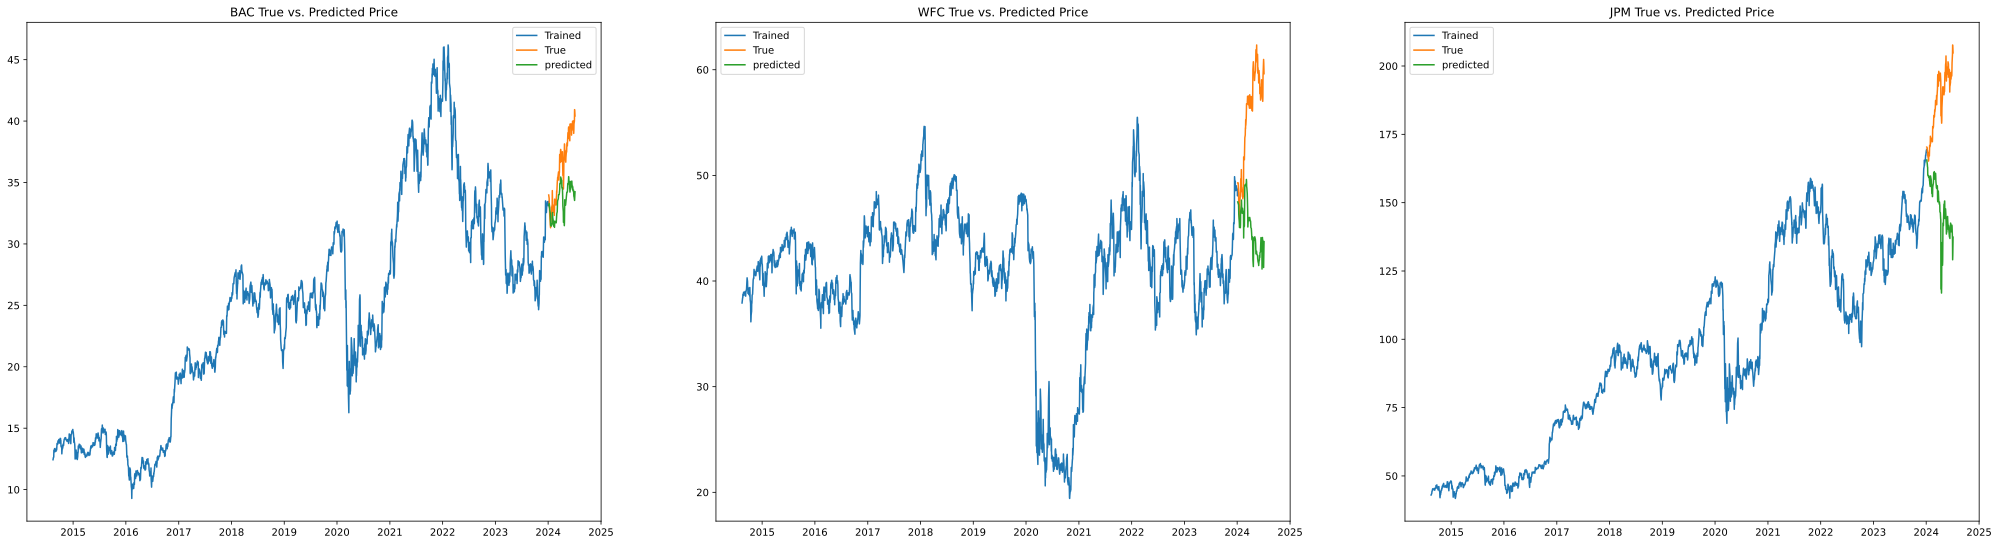

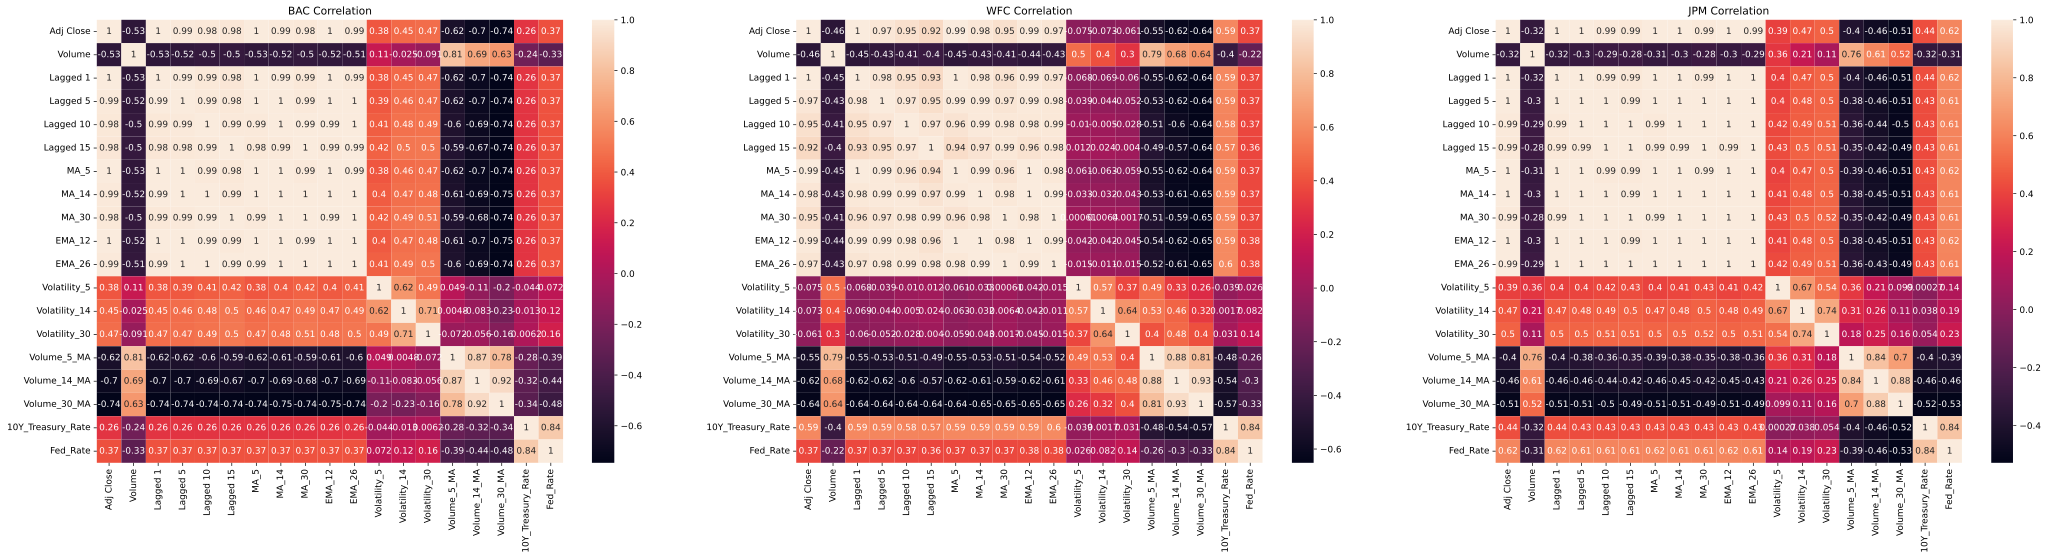

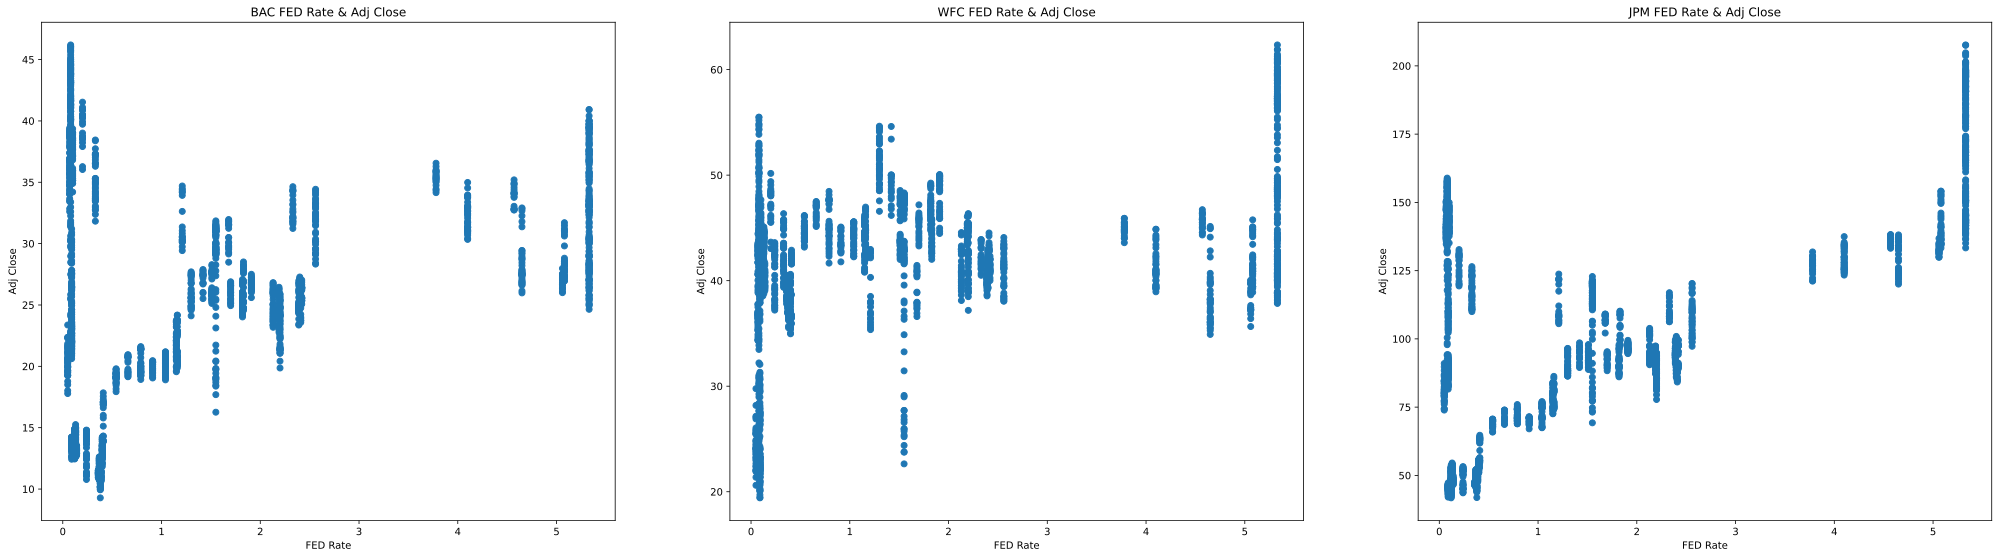

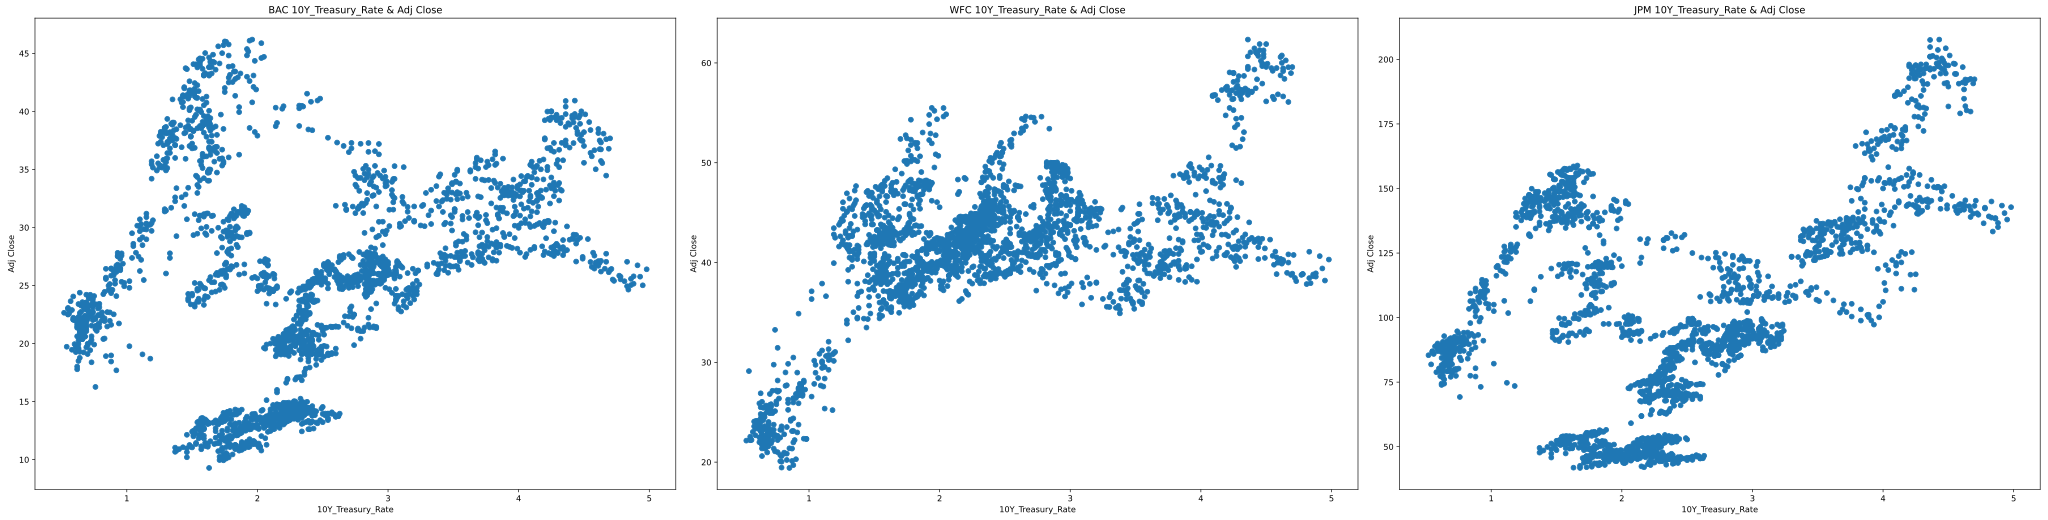

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=len(tickers), figsize=(35, 9))
fig1, axes1 = plt.subplots(nrows=1, ncols=len(tickers), figsize=(40, 9))
fig2, axes2 = plt.subplots(nrows=1, ncols=len(tickers), figsize=(35, 9))
fig3, axes3 = plt.subplots(nrows=1, ncols=len(tickers), figsize=(35, 9))


for index, stock in enumerate(tickers):
  stock_data = yf.download(stock, period = period)[['Adj Close', 'Volume']].copy()

  # Fearure Engineering

  # Lagged value
  for lag in [1, 5, 10, 15]:
    stock_data[f'Lagged {lag}'] = stock_data['Adj Close'].shift(lag)

  # Moving Averages
  for window in [5, 14, 30]:
    stock_data[f'MA_{window}'] = stock_data['Adj Close'].rolling(window).mean()

  # Exponential Moving Averages
  for span in [12, 26]:
    stock_data[f'EMA_{span}'] = stock_data['Adj Close'].ewm(span = span, adjust=False).mean()
  # Volatility Averages
  for vol in [5, 14, 30]:
    stock_data[f'Volatility_{vol}'] = stock_data['Adj Close'].rolling(vol).std()

  # Volume Averages
  for window in [5, 14, 30]:
    stock_data[f'Volume_{window}_MA'] = stock_data['Volume'].rolling(window).mean()

  # Fetch interest rate data from FRED
  start_date = stock_data.index.min().strftime('%Y-%m-%d')
  end_date = stock_data.index.max().strftime('%Y-%m-%d')

  interest_rate = web.DataReader('DGS10', 'fred', start_date, end_date)
  interest_rate.columns = ['10Y_Treasury_Rate']
  stock_data = stock_data.join(interest_rate, how='left')
  stock_data['10Y_Treasury_Rate'].fillna(method='ffill', inplace=True)

  # Fetch Federal Funds Rate data from FRED
  fed_rate = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)
  fed_rate.columns = ['Fed_Rate']
  stock_data = stock_data.join(fed_rate, how='left')
  stock_data['Fed_Rate'].fillna(method='ffill', inplace=True)

  stock_data.dropna(inplace = True)

  # Splitting the Dataset
  x = stock_data.drop(columns = 'Adj Close')
  y = stock_data['Adj Close']

  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=1, shuffle=False)

  scaled_x = StandardScaler()
  scaled_y = StandardScaler()

  x_train_scaled = scaled_x.fit_transform(x_train)
  x_test_scaled = scaled_x.transform(x_test)

  y_train_scaled = scaled_y.fit_transform(y_train.values.reshape((-1, 1)))
  y_test_scaled = scaled_y.transform(y_test.values.reshape((-1, 1)))

  # Training the model
  svr = SVR(kernel ='rbf')
  svr.fit(x_train_scaled, y_train_scaled.ravel())

  # Predict the model
  pred = scaled_y.inverse_transform(svr.predict(x_test_scaled).reshape(-1, 1))

  rmse = np.sqrt(mean_squared_error(y_test, pred))
  print(f'Root Mean Squared Error for {stock} prediction is: {rmse: .4f}')

  data = {
        'True Value': y_test.values.flatten(),
        'predicted': pred.flatten(),
        }

  test_results = pd.DataFrame(data, index = y_test.index)
  train_values = pd.DataFrame({'Trained Value': y_train})

  combined = pd.concat([train_values, test_results])

  # Visualize results with subplot
  ax = axes[index]
  ax.plot(combined, label=['Trained', 'True', 'predicted'])
  ax.set_title(f'{stock} True vs. Predicted Price')
  ax.legend()

  ax = axes1[index]
  cor = stock_data.corr()
  sns.heatmap(cor, annot=True, ax=ax)
  ax.set_title(f'{stock} Correlation')

  ax2 = axes2[index]
  ax2.scatter(stock_data['Fed_Rate'],stock_data['Adj Close'])
  ax2.set_title(f'{stock} FED Rate & Adj Close')
  ax2.set_xlabel('FED Rate')
  ax2.set_ylabel('Adj Close')

  ax3 = axes3[index]
  ax3.scatter(stock_data['10Y_Treasury_Rate'],stock_data['Adj Close'])
  ax3.set_title(f'{stock} 10Y_Treasury_Rate & Adj Close')
  ax3.set_xlabel('10Y_Treasury_Rate')
  ax3.set_ylabel('Adj Close')

plt.tight_layout()
plt.show()
